In [20]:
import sys
sys.path.append("../src/") 
import os

import model_manipulation as mm
import cobra
import cplex 
import libsbml
import pandas as pd
import copy
from pathlib import Path
import memote
import csv
import pytest
import matplotlib.pyplot as plt
import seaborn as sns

In [4]:
#Read 2-cell model
model = cobra.io.read_sbml_model("../model/ios2164_2cell.xml")
#Estimate inf
inf = 1e6
model.solver = 'gurobi'


Set parameter Username
Academic license - for non-commercial use only - expires 2022-06-12


In [5]:
#This codeblock is to define some functions that will be used for modelling.


#Define linear relationship between PPFD and Cellular maintainance costs
#This formula comes from Topfer et al (2020) where she defined NGAM in a linear relationship with incident light
def compute_ngam_atp(ppfd):
    v_atp = 0.0049*ppfd + 2.7851
    return v_atp


#This function is used to set the inputs to the model used. 
def define_model_medium(model, co2, o2, ppfd, 
                        medium_dir='../misc/photo_medium.csv', no3=inf, h2o=inf, h=inf, 
                        nh4=inf, pi=inf):
    model_photo_media = mm.read_medium_csv(medium_dir, model)
    model_photo_media['EX_no3(e)'] = no3
    model_photo_media['EX_h2o(e)'] = h2o
    model_photo_media['EX_h(e)'] = h
    model_photo_media['EX_nh4(e)'] = nh4
    model_photo_media['EX_co2(e)'] = co2
    model_photo_media['EX_o2(e)'] = o2
    model_photo_media['EX_photonVis(e)'] = ppfd
    model_photo_media['EX_pi(e)'] = pi
    #Set set model medium as model
#     print('Added model medium')
    return model_photo_media

    
def turn_off_cofac_cycles(model, inact_dir='../misc/leaf_inactivated.tsv'):
    file = csv.reader(open(inact_dir), delimiter='\t')
    leaf_inactive_rxns = list()
    for rows in file:
        row_m = str()
        row_bs = str()
        for rxns in rows:
            row_m += str(rxns) + "_M"
            row_bs += str(rxns) + "_BS"
        leaf_inactive_rxns.append(row_m)
        leaf_inactive_rxns.append(row_bs)
        
    for rxns in model.reactions:
        if rxns.id in leaf_inactive_rxns:
            rxns.bounds = (0,0)
#     print('Successfully turned off cofactor-cycling reactions')

    
# #Add constraints to model
#This code block contains constraints that would simulate the assimilation rates of bs and m cells in a two-cell system (such as those seen near the midvein region of rice leaves)
# #BS photon flux must be the same/less than M flux (Adapted from B&B, 2019)
# photon_import = model.reactions.get_by_id("EX_photonVis(e)")
def add_tissue_constraints(model):
    BS_photon_import = model.reactions.PRISM_white_LED_BS
    M_photon_import = model.reactions.PRISM_white_LED_M

    #Set photon flux ratio to 10:1
    photon_flux = mm.set_fix_flux_ratio({M_photon_import.id:10, BS_photon_import.id:1},model)
    model.add_cons_vars(photon_flux)

    co2tex_m = model.reactions.CO2tex_M
    co2tex_bs = model.reactions.CO2tex_BS

    #CO2 Uptake must be constrained to A (Net assimilation rate) which is around 29 +- 1.2 umol CO2 m-2 s-1 for wild type rice
    #CO2 BS intake must be limited owing to its position in the leaf tissue

    # # #CO2 intake needs to be mostly in the M cells. Not sure of the exact value:
    # # Values from Von Caemmerer (2000) in intermediate C3-C4 photosynthetic plants is 1 mmol CO2 m-2 s-1 per 20 CO2 m-2 s-1, which puts it at 20:1 ratio
    # # #try checking Danila et al. (2016) on ratio of surface area of M cell to BS cell
    # # #I'll assume that the ratio is at 20:1 in the meantime, meaning that there is minimal gas exchange into the BS cell that would equate to around ~1 umol CO2 m-2s-1
    co2_ratio_cons = mm.set_fix_flux_ratio({co2tex_m.id:10, co2tex_bs.id:1},model)
    co2_ratio_cons.name = 'co2_ratio_cons'
    model.add_cons_vars(co2_ratio_cons)

    #o2 ratio constraint
    o2tex_bs = model.reactions.O2tex_BS
    o2tex_m = model.reactions.O2tex_M

    o2_ratio_cons = mm.set_fix_flux_ratio({o2tex_m.id:10, o2tex_bs.id:1},model)
    o2_ratio_cons.name = 'o2_ratio_cons'
    model.add_cons_vars(o2_ratio_cons)

    #no tissue-specific constraints will be set for Nitrates, h2o and other inorganic cofactors as 
    #they are transported via the apoplastic pathway rather than the symplast

    # #This code block contains constraints specific for enzyme rate constraints
    #This approach is derived from Bogart & Myers (2016) where they constrained the enzyme rate 
    #fluxes in each of the 2-cell segments to a specific upper bound while keeping the lower bound
    #At 0. For reversible reactions the lower bounds are set to the same value

def add_enzyme_constraints(model):
    #Maximum values for constraints
    wt_pepc = 0 #umol m-2 s-1 #Note: Need to constrain it to 0 pala since no PEPC was detected in either cell type
    wt_mdh = 11.18 #umol m-2 s-1
    wt_nadp_me = 0.14 #umol m-2 s-1
    wt_ppdk = 0.31 #umol m-2 s-1
    wt_CA = 7.5 #umol m-2  s-1 bar-1 (Constrained to CO2 amounting to 400-500 mbar) (1 bar = 15.74 umol m-2 s-1 CA activity)

    #PEPC constraint (Reaction id: PPCc)
    #Need to constrain it to 0 since reaction is only detected in Vascular tissue
    pepc_BS = model.reactions.PPCc_BS
    pepc_M = model.reactions.PPCc_M

    wt_pepc_cons = model.problem.Constraint(pepc_BS.flux_expression 
                                            + pepc_M.flux_expression, 
                                            lb = 0, ub = wt_pepc)
    wt_pepc_cons.name = 'wt_pepc_cons'
    model.add_cons_vars(wt_pepc_cons)

    #PPDK constraints (Reaction id: PPDKs) (note that this is found in the chloroplast?) 
    #Not detected via immunolocalization but enzyme activity is detected

    ppdks_BS = model.reactions.PPDKs_BS
    ppdks_M = model.reactions.PPDKs_M
    wt_ppdks_cons = model.problem.Constraint(ppdks_BS.flux_expression 
                                             + ppdks_M.flux_expression, 
                                             lb = 0, ub = wt_ppdk)
    wt_ppdks_cons.name = 'wt_ppdks_cons'
    model.add_cons_vars(wt_ppdks_cons)
    #Malate Dehydrogenase 
    #Only mitochondrial in WT Rice M cells
    mdhm_M = model.reactions.MDHm_M


    wt_mdh_cons = model.problem.Constraint(mdhm_M.flux_expression,
                                           lb= 0, ub=wt_mdh)
    wt_mdh_cons.name = "wt_mdh_cons"
    model.add_cons_vars(wt_mdh_cons)

    #NADP-ME (Since no signal is detected in WT, no locational constraints are imposed)
    #Let's see if I can force it to have a small amount of flux 
    nadp_me_M = model.reactions.MDHys_M
    nadp_me_BS = model.reactions.MDHys_BS

    wt_nadpme_cons = model.problem.Constraint(nadp_me_M.flux_expression
                                             + nadp_me_BS.flux_expression,
                                             lb= 0, ub=wt_nadp_me)
    wt_nadpme_cons.name = "wt_nadpme_cons"
    model.add_cons_vars(wt_nadpme_cons)


    #I should add constraints for Carbonic Anhydrase
    #I should constrain it to 0.4 ubar, which would constitute ambient CO2 partial pressure
    #Flux is reversible so constraints are bi-directional


    hco3es_m = model.reactions.HCO3Es_M.flux_expression
    hco3ec_m = model.reactions.HCO3Ec_M.flux_expression
    hco3em_m = model.reactions.HCO3Em_M.flux_expression
    hco3es_bs = model.reactions.HCO3Es_BS.flux_expression
    hco3ec_bs = model.reactions.HCO3Ec_BS.flux_expression
    hco3em_bs = model.reactions.HCO3Em_BS.flux_expression

    ca_cons = model.problem.Constraint(hco3es_m + hco3ec_m + hco3em_m 
                                       + hco3es_bs + hco3ec_bs + hco3em_bs,
                                      lb = -wt_CA, ub = wt_CA)
    ca_cons.name = 'Carbonic_anhydrase_constraint'
    model.add_cons_vars(ca_cons)
    #Rbcl constaints
    #Retrieve flux expressions oof each RBCl reaction
    rbpc_M = model.reactions.RBPCs_M.flux_expression
    rbpc_BS = model.reactions.RBPCs_BS.flux_expression
    rbpo_M = model.reactions.RBPOs_M.flux_expression
    rbpo_BS = model.reactions.RBPOs_BS.flux_expression

    #Constraint such that it is limited to 132 umol m-2 s-1
    rbcl_vcmax_cons = model.problem.Constraint(rbpc_M + rbpc_BS, lb = 0, ub= 132)
    rbcl_vcmax_cons.name='rbcl_vcmax_cons'
    model.add_cons_vars(rbcl_vcmax_cons)
    #Constraints for rbcl flux such that v_c/v_o = 3 or higher.
    rbcl_vcvo = model.problem.Constraint(3*(rbpo_M + rbpo_BS) 
                                         - 1*(rbpc_M + rbpc_BS),
                                         lb=0,ub=1000)
    rbcl_vcvo.name = 'rbcl_vc/vo_ratio'
    model.add_cons_vars(rbcl_vcvo)

    #Turn off the RBPC2s reactions since we already defined the constraints above
    model.reactions.RBPC2s_M.bounds = (0,0)
    model.reactions.RBPC2s_BS.bounds = (0,0)
    
    
    
    #What if I simply constrained that of the M cell one to 3:1?
    #This constraint is pretty good actually. 
    #This allows the system to be set at a specific Vc/Vo rate while still allowing local variation 
    #wherein Rubisco may act in an uncoupled fashion and may have favorable internal vc/vo rates.
# #This code block is to set a constraint such that M-to-BS cell NGAM ratio is 10-to-1 
# #Similar to what Moreno-Villena (2021) (preprint) had done 

#This function takes two arguments: the model and the maximal  ppfd input to the system
def add_ngam_cons(model, ppfd): 
    ngam_atp_m = mm.get_rxn(model, 'ngam_atp_c_M')
    ngam_atp_bs = mm.get_rxn(model, 'ngam_atp_c_BS')
    ngam_atp_m.bounds = (0,1000)
    ngam_atp_bs.bounds = (0,1000)
    ngam_ratio = mm.set_fix_flux_ratio({ngam_atp_m.id:10, ngam_atp_bs.id:1}, model)
    ngam_ratio.name = 'ngam_BS/M_ratio'
    model.add_cons_vars(ngam_ratio)

    #Retrieve NGAM reactions
    ngam_nadphox_c_M = mm.get_rxn(model, 'ngam_nadphox_c_M')
    ngam_nadphox_s_M = mm.get_rxn(model, 'ngam_nadphox_s_M')
    ngam_nadphox_m_M = mm.get_rxn(model, 'ngam_nadphox_m_M')
    ngam_nadphox_c_BS = mm.get_rxn(model, 'ngam_nadphox_c_BS')
    ngam_nadphox_s_BS = mm.get_rxn(model, 'ngam_nadphox_s_BS')
    ngam_nadphox_m_BS = mm.get_rxn(model, 'ngam_nadphox_m_BS')


    #Set Fixed fluxes
    nadphox_c_s_M = mm.set_fix_flux_ratio({ngam_nadphox_c_M.id:1, ngam_nadphox_s_M.id:1},model)
    nadphox_c_s_M.name = "nadphox_cs_ratio_M"
    nadphox_s_m_M = mm.set_fix_flux_ratio({ngam_nadphox_s_M.id:1, ngam_nadphox_m_M.id:1}, model)
    nadphox_s_m_M.name = "nadphox_sm_ratio_M"

    nadphox_c_s_BS = mm.set_fix_flux_ratio({ngam_nadphox_c_BS.id:1, ngam_nadphox_s_BS.id:1},model)
    nadphox_c_s_BS.name = "nadphox_cs_ratio_BS"
    nadphox_s_m_BS = mm.set_fix_flux_ratio({ngam_nadphox_s_BS.id:1, ngam_nadphox_m_BS.id:1}, model)
    nadphox_s_m_BS.name = "nadphox_sm_ratio_BS"

    #Add constraints
    model.add_cons_vars(nadphox_c_s_M)
    model.add_cons_vars(nadphox_s_m_M)
    model.add_cons_vars(nadphox_c_s_BS)
    model.add_cons_vars(nadphox_s_m_BS)

    #Retrieve flux expressionns
    fex_nadphox_c_M =  mm.get_flux_exp(model, ngam_nadphox_c_M)
    fex_nadphox_s_M = mm.get_flux_exp(model, ngam_nadphox_s_M)
    fex_nadphox_m_M = mm.get_flux_exp(model, ngam_nadphox_m_M)

    fex_nadphox_c_BS =  mm.get_flux_exp(model, ngam_nadphox_c_BS)
    fex_nadphox_s_BS =  mm.get_flux_exp(model, ngam_nadphox_s_BS)
    fex_nadphox_m_BS =  mm.get_flux_exp(model, ngam_nadphox_m_BS)

    fex_atp_c_M = mm.get_flux_exp(model, ngam_atp_m)
    fex_atp_c_BS =  mm.get_flux_exp(model, ngam_atp_bs)

    #Set the constraint between ATP:NADPH NGAM to 3:1
    nadphox_atpase = model.problem.Constraint(3*(fex_nadphox_c_M + fex_nadphox_s_M + fex_nadphox_m_M
                                                       + fex_nadphox_c_BS + fex_nadphox_s_BS + fex_nadphox_m_BS) 
                                         - 1*(fex_atp_c_M + fex_atp_c_BS),
                                         lb=0,ub=0)
    nadphox_atpase.name = "nadphox_atpase_ratio"
    model.add_cons_vars(nadphox_atpase)
    #Compute NGAM value and add constraint as a lower bound/upper bound to model
    ngam_value = compute_ngam_atp(ppfd)
    ngam_cons = model.problem.Constraint(fex_atp_c_M + 
                                        fex_atp_c_BS, lb=ngam_value, ub=ngam_value)
    ngam_cons.name = 'NGAM_ATP_constraint'
    model.add_cons_vars(ngam_cons)
    
#This code  block gives a snapshot of the relevant fluxes on each of the cell types based on the saved sample_fluxes values above

def print_summary(sample_fluxes_df):
    print('rbcl M cell: ', sample_fluxes['RBPCs_M'], 'rbcl BS cell: ',sample_fluxes['RBPCs_BS'])
    print('rbcl M cell (photorespiration)', sample_fluxes['RBPOs_M'], 'rbcl BS cell (PR)', sample_fluxes['RBPOs_BS'])
    print('vc/vo M:', sample_fluxes['RBPCs_M']/sample_fluxes['RBPOs_M'], 'vc/vo BS:', sample_fluxes['RBPCs_BS']/sample_fluxes['RBPOs_BS'])
    print('RBPC2s_M', sample_fluxes['RBPC2s_M'], 'RBPC2s_BS', sample_fluxes['RBPC2s_BS'])
    print('PEPC M', sample_fluxes['PPCc_M'], 'PEPC BS', sample_fluxes['PPCc_BS'])
    print('Carbonic Anhydrase (Cytosolic) M', sample_fluxes['HCO3Ec_M'], 'Carbonic Anhydrase (Cytosolic) BS', sample_fluxes['HCO3Ec_BS'])
    print('NADP-ME M', sample_fluxes['MDHys_M'], 'NADP-ME BS', sample_fluxes['MDHys_BS'])
    print('Biomass M: ', sample_fluxes['Straw_Biomass_M'], 'Biomass BS', sample_fluxes['Straw_Biomass_BS'])
    print('Phloem M: ', sample_fluxes['DM_Phloem_M'], 'Phloem BS', sample_fluxes['DM_Phloem_BS'])
    print('co2 consumption M', sample_fluxes['CO2tex_M'], 'co2 consumption BS', sample_fluxes['CO2tex_BS'])
    print('o2 consumption M', sample_fluxes['O2tex_M'], 'o2 consumption BS', sample_fluxes['O2tex_BS'])
    print('Photosystem II M', sample_fluxes['PSIINC_M'], 'PSII BS', sample_fluxes['PSIINC_BS'])
    print('PSI M', sample_fluxes['PSIMR_M'], 'PSI BS', sample_fluxes['PSIMR_BS'])
    print('PPFD M: ', sample_fluxes['PRISM_white_LED_M'], 'PPFD BS: ', sample_fluxes['PRISM_white_LED_BS'])
    print('ATP synthesis (stromal) M', sample_fluxes['ATPSs_M'], 'ATP synthase (mit) M', sample_fluxes['ATPSm_M'])
    pd_rxn = [x for x in model.reactions if "pd" in x.id and "h2o" not in x.id]
    pd_abs_flux = 0
    for pds in pd_rxn:
        pd_abs_flux += abs(sample_fluxes[pds.id])
    
    print('pd_abs_flux: ', pd_abs_flux)

This code block is to add the constraints for ngam nadphox, which for some reason doesn't save when it was generated using the curation script


In [6]:
# This code block is to test whether a single iteration works. Maybe I should implement the kinetic constraints by Von Caemmerer to obtain proper 
#proper values? I think that would be a better approach, I think.


with model as m1:
                                                                                                                                                                                                                                                                                                                      
    m1.medium = define_model_medium(m1, co2=29, o2=2.26, ppfd=0, h=inf, nh4=inf, no3=inf)
    turn_off_cofac_cycles(m1) #Turn off other cofactor recycling 
    add_tissue_constraints(m1)
    add_enzyme_constraints(m1)
    add_ngam_cons(m1, 0)

    #Constrain O2 intake to 3.312 mmol O2 gcw -1 d-1 ~~ 2.2618 umol O2 m-2 s-1 (from Lakshmanan et al. 2016)
    #Change objective function to mature leaf
    model.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
    model.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
    mm.get_rxn(model,'DM_Phloem_BS').objective_coefficient = 1
    sample_fluxes = cobra.flux_analysis.pfba(model).fluxes
    #Remove thermodynamically infeasible loops
    sample_fluxes = cobra.flux_analysis.loopless_solution(model, sample_fluxes)
    sample_fluxes_df = sample_fluxes.to_frame()


print_summary(sample_fluxes_df)


rbcl M cell:  2.2738520485400446 rbcl BS cell:  0.22239900051760136
rbcl M cell (photorespiration) 0.7859434565375173 rbcl BS cell (PR) 0.046140226481698
vc/vo M: 2.893149665699267 vc/vo BS: 4.820067378859058
RBPC2s_M 0.0 RBPC2s_BS 0.0
PEPC M 0.0 PEPC BS 0.0
Carbonic Anhydrase (Cytosolic) M -0.003204753032265613 Carbonic Anhydrase (Cytosolic) BS 0.0
NADP-ME M 0.0 NADP-ME BS 0.0
Biomass M:  0.0 Biomass BS 0.0
Phloem M:  0.0 Phloem BS 0.03345253687124857
co2 consumption M 1.8884887652572853 co2 consumption BS 0.18884887652572854
o2 consumption M 2.0545454545454542 o2 consumption BS 0.20545454545454545
Photosystem II M 0.0 PSII BS 0.0
PSI M 0.0 PSI BS 0.0
PPFD M:  0.0 PPFD BS:  0.0
ATP synthesis (stromal) M 0.0 ATP synthase (mit) M 14.120084089809437
pd_abs_flux:  0.5429491897939372


In [16]:
ppfd_solns_2cell_fba = pd.DataFrame(index=list(i.id for i in model.reactions))

#Iterate from range 0 to 2000 w/ increments of 50 (max ppfd)

for ppfd in range(0,2000,25):
    
    #Generate instance of model every iteration
    with model as m1:
        #Set ATP NGAM value to linear PPFD formula

         #Set medium to change photon flux and other things and re-add to model
        m1.medium = define_model_medium(m1, co2=29, o2=2.216, ppfd=ppfd, h=inf, nh4=inf, no3=inf)
        turn_off_cofac_cycles(m1)
        add_tissue_constraints(m1)
        add_enzyme_constraints(m1)
        add_ngam_cons(m1, ppfd)

        #Change objective function to mature leaf
        m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 0
        m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 0
        m1.reactions.get_by_id('DM_Phloem_BS').objective_coefficient = 1

        #Optimize then check optimality
        while True:
            solution = model.optimize()
            if solution.status == 'optimal':
                sample_fluxes = cobra.flux_analysis.pfba(model).fluxes
                #Remove thermodynamically infeasible loops via CycleFreeFlux algorithm
                sample_fluxes = cobra.flux_analysis.loopless_solution(model, sample_fluxes).to_frame()
                print("PPFD:", ppfd, " RBPC_M cell flux:", sample_fluxes['fluxes']['RBPCs_M'])
                #Append to Dataframe
                ppfd_solns_2cell_fba[ppfd] = sample_fluxes['fluxes']
                break
            else:
                continue


filepath = '../flux_results/PPFD_benchmark/WT/'
filename = 'PPFD-benchmark-turned-on-FDHNc'
mm.save_fba_matrix(filename, ppfd_solns_2cell_fba, filepath)

PPFD: 0  RBPC_M cell flux: 2.206193356016916
PPFD: 25  RBPC_M cell flux: 4.473276390514303
PPFD: 50  RBPC_M cell flux: 6.669758814699076
PPFD: 75  RBPC_M cell flux: 8.94657910932838
PPFD: 100  RBPC_M cell flux: 11.071107861555317
PPFD: 125  RBPC_M cell flux: 13.205765885216623
PPFD: 150  RBPC_M cell flux: 15.344514241405534
PPFD: 175  RBPC_M cell flux: 17.485100225658172
PPFD: 200  RBPC_M cell flux: 19.64029134708449
PPFD: 225  RBPC_M cell flux: 21.795935886599715
PPFD: 250  RBPC_M cell flux: 23.95158042611643
PPFD: 275  RBPC_M cell flux: 26.107224965626838
PPFD: 300  RBPC_M cell flux: 28.26286950514963
PPFD: 325  RBPC_M cell flux: 30.41851404463545
PPFD: 350  RBPC_M cell flux: 31.80420172405801
PPFD: 375  RBPC_M cell flux: 31.902988860963806
PPFD: 400  RBPC_M cell flux: 31.728258940794806
PPFD: 425  RBPC_M cell flux: 31.677953254185965
PPFD: 450  RBPC_M cell flux: 31.90706430852436
PPFD: 475  RBPC_M cell flux: 29.60532042522177
PPFD: 500  RBPC_M cell flux: 31.812195226398995
PPFD: 525

In [17]:
#Run the simulation above  but setting biomass as primary

ppfd_solns_2cell_fba_bm = pd.DataFrame(index=list(i.id for i in model.reactions))

#Iterate from range 0 to 2000 w/ increments of 50 (max ppfd)

for ppfd in range(0,2000,25):
    
    #Generate instance of model every iteration
    with model as m1:
        #Set ATP NGAM value to linear PPFD formula

         #Set medium to change photon flux and other things and re-add to model
        m1.medium = define_model_medium(m1, co2=29, o2=2.216, ppfd=ppfd, h=inf, nh4=inf, no3=inf)
        turn_off_cofac_cycles(m1)
        add_tissue_constraints(m1)
        add_enzyme_constraints(m1)
        add_ngam_cons(m1, ppfd)
    


        #Change objective function to mature leaf
        m1.reactions.get_by_id('Straw_Biomass_M').objective_coefficient = 1
        m1.reactions.get_by_id('Straw_Biomass_BS').objective_coefficient = 1
        m1.reactions.get_by_id('DM_Phloem_BS').objective_coefficient = 0

        #Optimize then check optimality, repeat until solution is optimal
        while True:
            solution = model.optimize()

            if solution.status == 'optimal':
                sample_fluxes = cobra.flux_analysis.pfba(model).fluxes
                #Remove thermodynamically infeasible loops via CycleFreeFlux algorithm
                sample_fluxes = cobra.flux_analysis.loopless_solution(model, sample_fluxes).to_frame()

                print("PPFD:", ppfd, " RBPC_M cell flux:", sample_fluxes['fluxes']['RBPCs_M'])
                #Append to Dataframe
                ppfd_solns_2cell_fba_bm[ppfd] = sample_fluxes['fluxes']
                
                break


filepath = '../flux_results/PPFD_benchmark/WT/'
filename = 'PPFD-benchmark-growing-leaf'
mm.save_fba_matrix(filename, ppfd_solns_2cell_fba_bm, filepath)

PPFD: 0  RBPC_M cell flux: 2.1588628163738353
PPFD: 25  RBPC_M cell flux: 4.427787340772136
PPFD: 50  RBPC_M cell flux: 6.618511943703553
PPFD: 75  RBPC_M cell flux: 8.866417274954935
PPFD: 100  RBPC_M cell flux: 11.146370816895633
PPFD: 125  RBPC_M cell flux: 13.409989193672871
PPFD: 150  RBPC_M cell flux: 15.655539656906903
PPFD: 175  RBPC_M cell flux: 17.76763476202759
PPFD: 200  RBPC_M cell flux: 19.999193481491954
PPFD: 225  RBPC_M cell flux: 22.286318187731027
PPFD: 250  RBPC_M cell flux: 24.63774150984394
PPFD: 275  RBPC_M cell flux: 26.716958831826833
PPFD: 300  RBPC_M cell flux: 29.0232464445144
PPFD: 325  RBPC_M cell flux: 31.37439289956965
PPFD: 350  RBPC_M cell flux: 32.611151861319
PPFD: 375  RBPC_M cell flux: 32.37016521655663
PPFD: 400  RBPC_M cell flux: 32.86839694207268
PPFD: 425  RBPC_M cell flux: 33.03400660179573
PPFD: 450  RBPC_M cell flux: 32.88087759538894
PPFD: 475  RBPC_M cell flux: 32.958500723155154
PPFD: 500  RBPC_M cell flux: 32.576150995339475
PPFD: 525  R

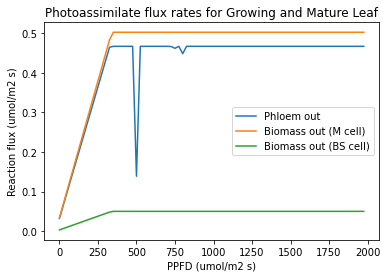

In [110]:
#Let's graph the initial results first

#plot PPFD vs CO2 uptake

co2_e = ppfd_solns_2cell_fba.loc[['EX_co2(e)']].values.flatten()
o2_e =ppfd_solns_2cell_fba.loc[['EX_o2(e)']].values.flatten()
nh4_e =  ppfd_solns_2cell_fba.loc[['EX_nh4(e)']].values.flatten()
no3_e =  ppfd_solns_2cell_fba.loc[['EX_no3(e)']].values.flatten()
phloem_out = ppfd_solns_2cell_fba.loc[['DM_Phloem_BS']].values.flatten()
biomass_out_M = ppfd_solns_2cell_fba_bm.loc[['Straw_Biomass_M']].values.flatten()
biomass_out_BS = ppfd_solns_2cell_fba_bm.loc[['Straw_Biomass_BS']].values.flatten()
ppfd_e = list(ppfd_solns_2cell_fba.columns)

plt.plot(ppfd_e, phloem_out, label="Phloem out")
plt.plot(ppfd_e, biomass_out_M, label="Biomass out (M cell)")
plt.plot(ppfd_e, biomass_out_BS, label="Biomass out (BS cell)")
plt.title(label='Photoassimilate flux rates for Growing and Mature Leaf')
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('Reaction flux (umol/m2 s)')
plt.legend()
plt.show()

#Based on the plot below, It shows that FDHNC activity is 

#I think I need to graph previous data regarding this?

In [ ]:
#Show CO2 

In [ ]:
#Model also facilitates transfer of metabolites unlike before.

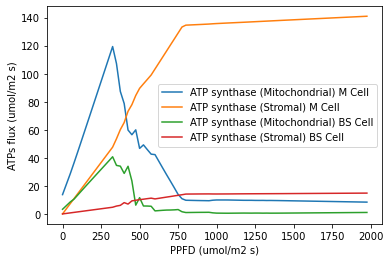

In [111]:
# Plot ATPs_M and ATPSs vs. ppfd
ATPSm_m =  ppfd_solns_2cell_fba.loc[['ATPSm_M']].values.flatten()
ATPSs_m =  ppfd_solns_2cell_fba.loc[['ATPSs_M']].values.flatten()
ATPSm_bs = ppfd_solns_2cell_fba.loc[['ATPSm_BS']].values.flatten()
ATPSs_bs = ppfd_solns_2cell_fba.loc[['ATPSs_BS']].values.flatten()




plt.plot(ppfd_e, ATPSm_m, label="ATP synthase (Mitochondrial) M Cell")
plt.plot(ppfd_e, ATPSs_m, label="ATP synthase (Stromal) M Cell")
plt.plot(ppfd_e, ATPSm_bs, label="ATP synthase (Mitochondrial) BS Cell")
plt.plot(ppfd_e, ATPSs_bs, label="ATP synthase (Stromal) BS Cell")
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('ATPs flux (umol/m2 s)')
plt.legend()
plt.show()


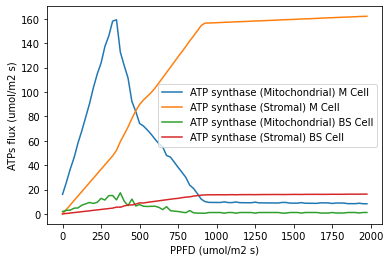

In [112]:
# Plot ATPs_M and ATPSs vs. ppfd in growing leaf
ATPSm_m =  ppfd_solns_2cell_fba_bm.loc[['ATPSm_M']].values.flatten()
ATPSs_m =  ppfd_solns_2cell_fba_bm.loc[['ATPSs_M']].values.flatten()
ATPSm_bs = ppfd_solns_2cell_fba_bm.loc[['ATPSm_BS']].values.flatten()
ATPSs_bs = ppfd_solns_2cell_fba_bm.loc[['ATPSs_BS']].values.flatten()



plt.plot(ppfd_e, ATPSm_m, label="ATP synthase (Mitochondrial) M Cell")
plt.plot(ppfd_e, ATPSs_m, label="ATP synthase (Stromal) M Cell")
plt.plot(ppfd_e, ATPSm_bs, label="ATP synthase (Mitochondrial) BS Cell")
plt.plot(ppfd_e, ATPSs_bs, label="ATP synthase (Stromal) BS Cell")
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('ATPs flux (umol/m2 s)')
plt.legend()
plt.show()


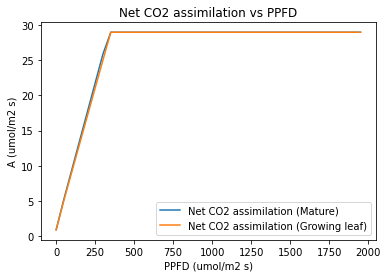

In [90]:
#Show CO2 assimilation comparing growing leaf and mature leaf
co2_e_mature = ppfd_solns_2cell_fba.loc[['EX_co2(e)']].values.flatten()
co2_e_growing = ppfd_solns_2cell_fba_bm.loc[['EX_co2(e)']].values.flatten()

plt.plot(ppfd_e, co2_e_mature *-1, label='Net CO2 assimilation (Mature)')
plt.plot(ppfd_e, co2_e_growing *-1, label='Net CO2 assimilation (Growing leaf)')
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('A (umol/m2 s)')
plt.title('Net CO2 assimilation vs PPFD')
plt.legend()
plt.show()

#Weirdly enough it shows the same response

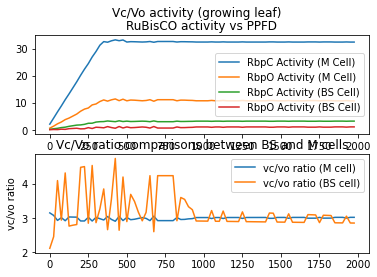

In [134]:
#Let's plot the RBCL activities per PPFD
rbpc_m = ppfd_solns_2cell_fba_bm.loc[['RBPCs_M']].values.flatten()
rbpo_m = ppfd_solns_2cell_fba_bm.loc[['RBPOs_M']].values.flatten()
rbpc_bs = ppfd_solns_2cell_fba_bm.loc[['RBPCs_BS']].values.flatten()
rbpo_bs = ppfd_solns_2cell_fba_bm.loc[['RBPOs_BS']].values.flatten()
vcvo_m = rbpc_m/rbpo_m
vcvo_bs = rbpc_bs/rbpo_bs



fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Vc/Vo activity (growing leaf)')
# fig.set_xlabel('PPFD (umol/m2 s)')

ax1.plot(ppfd_e,  rbpc_m, label='RbpC Activity (M Cell)')
ax1.plot(ppfd_e, rbpo_m, label='RbpO Activity (M Cell)')
ax1.plot(ppfd_e,  rbpc_bs, label='RbpC Activity (BS Cell)')
ax1.plot(ppfd_e, rbpo_bs, label='RbpO Activity (BS Cell)')
ax1.set_xlabel('RubisCO Flux (umol/m2 s)')
ax1.set_title('RuBisCO activity vs PPFD')
ax1.legend()


ax2.plot(ppfd_e,  vcvo_m, label='vc/vo ratio (M cell)')
ax2.plot(ppfd_e, vcvo_bs, label='vc/vo ratio (BS cell)')
ax2.set_ylabel('vc/vo ratio')
ax2.set_title('Vc/Vo ratio comparisons between BS and M cells')
ax2.legend()



<ipython-input-164-8cb069eebe39>:7: RuntimeWarning: divide by zero encountered in true_divide
  vcvo_bs = rbpc_bs/rbpo_bs


Text(0, 0.5, 'vc/vo ratio')

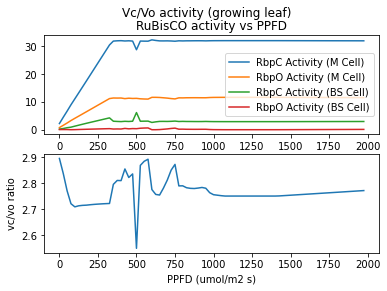

In [164]:
#Let's plot the RBCL activities per PPFD
rbpc_m = ppfd_solns_2cell_fba.loc[['RBPCs_M']].values.flatten()
rbpo_m = ppfd_solns_2cell_fba.loc[['RBPOs_M']].values.flatten()
rbpc_bs = ppfd_solns_2cell_fba.loc[['RBPCs_BS']].values.flatten()
rbpo_bs = ppfd_solns_2cell_fba.loc[['RBPOs_BS']].values.flatten()
vcvo_m = rbpc_m/rbpo_m
vcvo_bs = rbpc_bs/rbpo_bs

vcvo_total = (rbpc_m + rbpc_bs)/(rbpo_m + rbpo_bs)


fig, (ax1, ax2) = plt.subplots(2)
fig.suptitle('Vc/Vo activity (mature leaf)')

ax1.plot(ppfd_e,  rbpc_m, label='RbpC Activity (M Cell)')
ax1.plot(ppfd_e, rbpo_m, label='RbpO Activity (M Cell)')
ax1.plot(ppfd_e,  rbpc_bs, label='RbpC Activity (BS Cell)')
ax1.plot(ppfd_e, rbpo_bs, label='RbpO Activity (BS Cell)')
ax1.set_ylabel('RbpC/RbpO activity (umol m2/s)')
ax1.set_title('RuBisCO activity vs PPFD')
ax1.legend()

# ax2(ppfd_e,  vcvo_bs, label='vc/vo ratio (BS cell)')
ax2.plot(ppfd_e, vcvo_m, label='vc/vo ratio (M cell)')
ax2.set_xlabel('PPFD (umol/m2 s)')
ax2.set_ylabel('vc/vo ratio')
ax2.legend()
# ax2.set_title('Vc/Vo ratio comparisons between BS and M cells')


#Top is rubisco fluxes while bottom is vc/vo ratios. Note that the vc/vo ratios at the bottom portion 
#are disrupted due to zero values in a number of 

<AxesSubplot:>

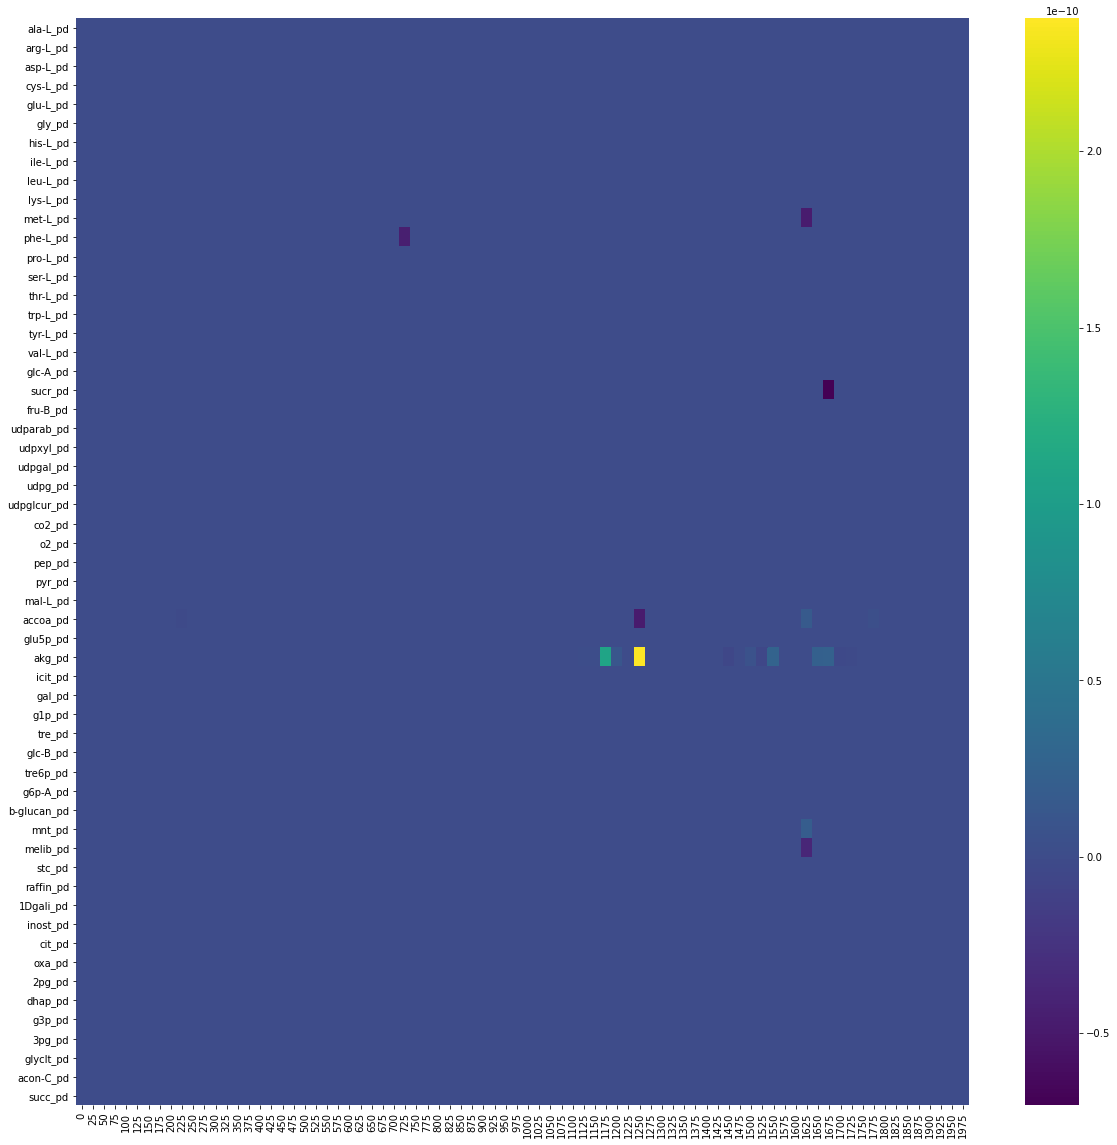

In [40]:
#This heat map shows the Plasmodesmatal reactions in a growing leaf
phloem_ppfd = ppfd_solns_2cell_fba_bm.transpose()
pd_transport_ids = [rxns.id for rxns in model.reactions if "_pd" in rxns.id and "h2o" not in rxns.id]

pd_phloem_ppfd_bm = phloem_ppfd[pd_transport_ids].transpose().replace()



plt.figure(figsize = (20,20))
sns.heatmap(pd_phloem_ppfd_bm, cmap='viridis')

In [39]:
#This code block is to generate a bar graph showing PD sum of fluxes  per ppfd

pd_phloem_abs_flux_bm = pd_phloem_ppfd.abs().sum(axis=0)
# pd_phloem_abs_flux_bm

# plt.plot(pd_phloem_abs_flux_bm.index, pd_phloem_abs_flux_bm.values, label='Sum abs. PD metabolite fluxes')
# plt.xlabel('PPFD (umol/m2 s)')
# plt.ylabel('Sum(abs(PD fluxes))')
# plt.title('Plot of Absolute fluxes for PD')
# plt.legend()
# plt.show


<AxesSubplot:>

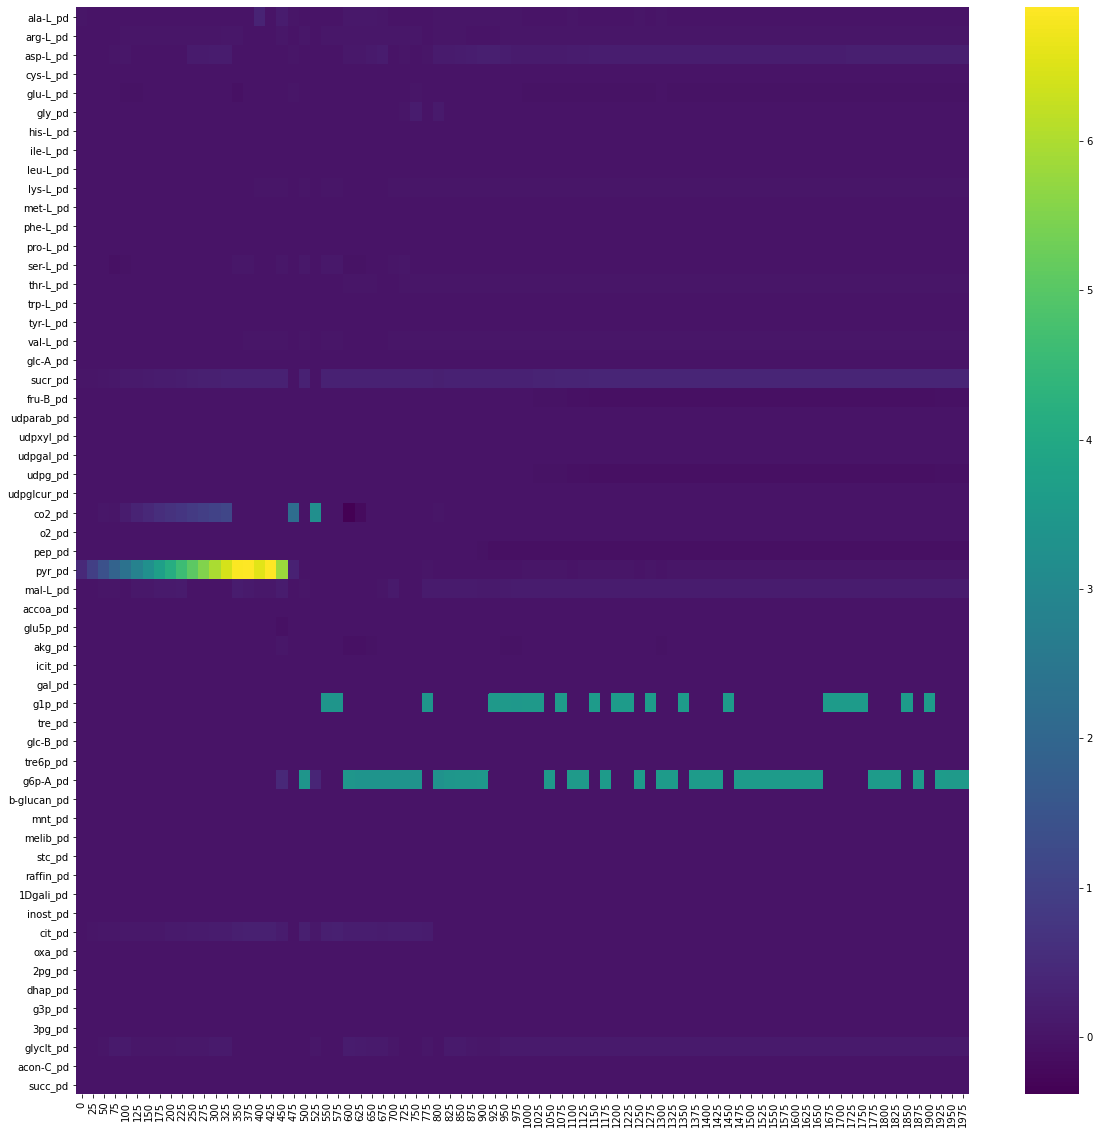

In [36]:
phloem_ppfd = ppfd_solns_2cell_fba.transpose()

pd_transport_ids = [rxns.id for rxns in model.reactions if "_pd" in rxns.id and "h2o" not in rxns.id]

pd_phloem_ppfd = phloem_ppfd[pd_transport_ids].transpose()
pd_phloem_ppfd.loc[~(pd_phloem_ppfd<-inf).all(axis=1)]
pd_phloem_ppfd


plt.figure(figsize = (20,20))
sns.heatmap(pd_phloem_ppfd, cmap='viridis')

<function matplotlib.pyplot.show(close=None, block=None)>

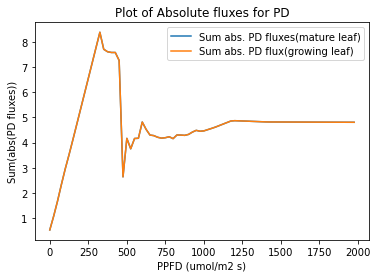

In [37]:
#This code block is to generate a bar graph showing PD sum of fluxes  per ppfd

pd_phloem_abs_flux = pd_phloem_ppfd.abs().sum(axis=0)


plt.plot(pd_phloem_abs_flux.index, pd_phloem_abs_flux, label='Sum abs. PD fluxes(mature leaf)')
plt.plot(pd_phloem_abs_flux_bm.index, pd_phloem_abs_flux_bm.values, label = 'Sum abs. PD flux(growing leaf)')
plt.xlabel('PPFD (umol/m2 s)')
plt.ylabel('Sum(abs(PD fluxes))')
plt.title('Plot of Absolute fluxes for PD')
plt.legend()
plt.show


In [ ]:
#Constraining O2 consumption to around 3.312 forces water to be consumed by the system, unlike when O2 is unconstrained.
#However, the same behavior when it comes to CO2 assimilation still is being produced.
#Constraining O2 consumption also forces Nitrate consumption to be constrained to realistic levels (when compared to non-constrained O2 where consumption was 10-fold )
#I suspect that this is definitely due to how PPFD flux is structured. 
#A cop-out to this would be to double PPFD per run and measuring PPFD flux in the specific reactions instead.

In [ ]:
#I can probably do the benchmarking right now. The model behaves quite interestingly actually

In [ ]:
#Note: Turning off other prism reactions (red, green, blue, etc) while retaining only white light reactions lowers net carbon assimilation
#I think this is in consideration on how white light is partitioned to several wavelengths, which prevents it from being fully utilized.

In [ ]:
#Other artifacts as of the moment include the following:
#model doesn't produce any Oxygen. Maybe I should add a specific demand reaction for it?
#Based on FVA, the model now produces some oxygen via the demand reaction. 

In [ ]:
#Questions:
#Should I restrict Nutrient flow to the Bundle Sheath Cell only or should I allow flux to both the M and BS cell?
#Apparently kasi dito only the Bundle sheath cells produce any biomass
#This is to ensure that only CO2 and Light flux are the only limiting constraints to the system.